In [3]:
import sys, os

import numpy as np

sys.path.append('../../neural_network_dynamics/')
import nrn
from utils import plot_tools as pt

## Load morphology

In [4]:
Model = {
    #################################################
    # ---------- MORPHOLOGY PARAMS  --------------- #
    #################################################
    'Nbranch':4, # 
    'branch_length':100, # [um]
    'radius_soma':10, # [um]
    'diameter_root_dendrite':1.0, # [um]
    'nseg_per_branch': 10,
    ##################################################
    # ---------- BIOPHYSICAL PROPS ----------------- #
    ##################################################
    "gL": 0.5, # [pS/um2] = 10*[S/m2] # FITTED --- Farinella et al. 0.5pS/um2 = 0.5*1e-12*1e12 S/m2, NEURON default: 1mS/cm2 -> 10pS/um2
    "cm": 1., # [uF/cm2] NEURON default
    "Ri": 100., # [Ohm*cm]
    "EL": -75, # [mV]
    #################################################
    # ---------- MG-BLOCK PARAMS  ----------------- #
    #################################################
    'cMg': 1., # mM
    'etaMg': 0.33, # 1/mM
    'V0NMDA':1./0.08,# [mV]
    'Mg_NMDA':1.,# mM
    #################################################
    # ---------- SYNAPTIC PARAMS  ----------------- #
    #################################################
    'Ee':0,# [mV]
    'qAMPA':0.3,# [nS] # Destexhe et al., 1998: "0.35 to 1.0 nS"
    'qNMDAtoAMPAratio': 2.5,
    'tauRiseAMPA':0.5,# [ms], Destexhe et al. 1998: 0.4 to 0.8 ms
    'tauDecayAMPA':5,# [ms], Destexhe et al. 1998: "the decay time constant is about 5 ms (e.g., Hestrin, 1993)"
    'tauRiseNMDA': 3,# [ms], Farinella et al., 2014
    'tauDecayNMDA': 70,# [ms], FITTED --- Destexhe et al.:. 25-125ms, Farinella et al., 2014: 70ms
    ###################################################
    # ---------- SIMULATION PARAMS  ----------------- #
    ###################################################
    'dt':0.025,# [ms]
    'seed':1, #
    'interstim':250, # [ms]
}    



In [5]:
BRT = nrn.morphologies.BallandRallsTree.build_morpho(Nbranch=Model['Nbranch'],
                                                     branch_length=Model['branch_length'],
                                                     soma_radius=Model['radius_soma'],
                                                     root_diameter=Model['diameter_root_dendrite'],
                                                     Nperbranch=Model['nseg_per_branch'])
FULL = nrn.morpho_analysis.compute_segments(BRT)
SEGMENTS = nrn.morpho_analysis.compute_segments(BRT, without_axon=True)

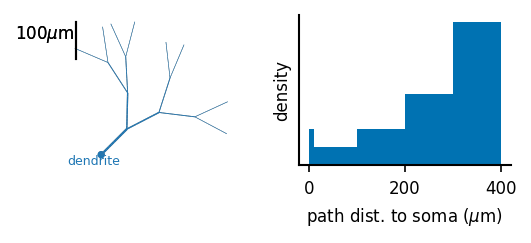

In [7]:
fig, [ax0, ax] = pt.plt.subplots(1, 2, figsize=(4,1.3))
visFull, vis = pt.nrnvyz(FULL), pt.nrnvyz(SEGMENTS)
visFull.plot_segments(ax=ax0, color='tab:grey')
ax0.annotate('dendrite', (0,0), xycoords='axes fraction', fontsize=6, color='tab:blue')
vis.plot_segments(ax=ax0, color='tab:blue')
ax.hist(1e6*SEGMENTS['distance_to_soma'], density=True,
        bins=np.linspace(0, Model['branch_length']*Model['Nbranch'],
                        Model['nseg_per_branch']*Model['Nbranch']+1))
ax.set_xlabel('path dist. to soma ($\mu$m)')
ax.set_ylabel('density')
ax.set_yticks([]);

## Distribute synapses on a single dendritic branch

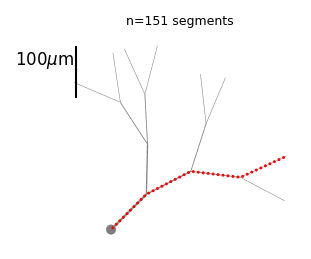

In [8]:
# select a given dendrite, the longest one !
iEndDendrite = np.argmax(SEGMENTS['distance_to_soma'])
SETS, i = [SEGMENTS['name'][iEndDendrite]], 0
while (i<10) and len(SETS[-1].split('.'))>1:
    new_name =  '.'.join(SETS[-1].split('.')[:-1])
    SETS.append(new_name)
    i+=1
BRANCH_LOCS = []
for i, name in enumerate(SEGMENTS['name']):
    if name in SETS:
        BRANCH_LOCS.append(i)

fig, ax = pt.plt.subplots(1, figsize=(2,2))
vis.plot_segments(ax=ax, color='tab:grey')
vis.add_dots(ax, BRANCH_LOCS, 2)
ax.set_title('n=%i segments' % len(SEGMENTS['name']), fontsize=6)
BRANCH_LOCS = np.array(BRANCH_LOCS, dtype=int)

In [11]:
x = np.linspace(SEGMENTS['distance_to_soma'][BRANCH_LOCS].min(),
                SEGMENTS['distance_to_soma'][BRANCH_LOCS].max(), len(BRANCH_LOCS))
uniform = 0.5 +0*x
uniform /= np.sum(uniform) #np.trapz(uniform, x=1e6*x)

biased = 1.-(x-x.min())/(x.max()-x.min())
biased /= np.sum(biased) # np.trapz(biased, x=1e6*x)

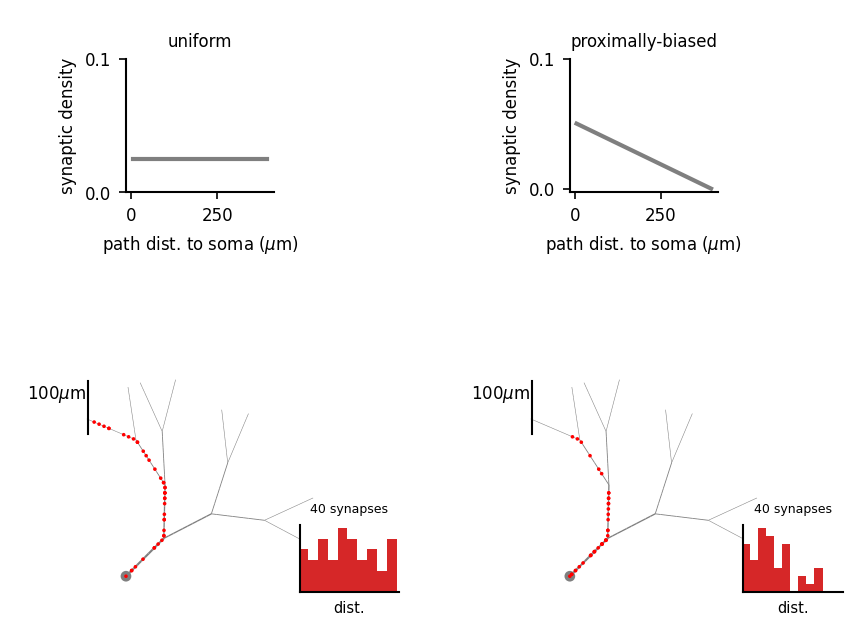

In [14]:
Nsynapses = len(BRANCH_LOCS)

np.random.seed(7)
LOCS = {}

digitized_dist = np.digitize(SEGMENTS['distance_to_soma'][BRANCH_LOCS], bins=x, right=True)

for case, proba in zip(['uniform', 'proximally-biased'], [uniform, biased]):
    LOCS[case] = np.random.choice(np.arange(len(x)),
                                  Nsynapses, 
                                  p=proba)
    
LOCS['single-syn'] = BRANCH_LOCS # to have them all

fig, AX = pt.plt.subplots(2, 2, figsize=(7,5))
pt.plt.subplots_adjust(wspace=.2, hspace=.6)

for c, y, case in zip(range(2), [uniform, biased], ['uniform', 'proximally-biased']):
    
    ax=pt.inset(AX[0][c], [0.3, 0.2, 0.4, 0.6])
    ax.set_ylabel('synaptic density')
    AX[0][c].axis('off')
    ax.plot(1e6*x, y, '-', color='tab:grey', lw=2)
    ax.set_yticks([0,0.1])
    ax.set_title(case)
    ax.set_xlabel('path dist. to soma ($\mu$m)');
    
    vis.plot_segments(ax=AX[1][c], color='tab:grey')
    vis.add_dots(AX[1][c], LOCS[case], 3)

    inset = pt.inset(AX[1][c], [0.9, 0., 0.4, 0.3])
    inset.hist(SEGMENTS['distance_to_soma'][LOCS[case]], bins=10, color='tab:red')
    inset.set_xlabel('dist.', fontsize=7);inset.set_xticks([]);inset.set_yticks([])
    inset.set_xlim([x.min(), x.max()])
    inset.set_title('%i synapses' % Nsynapses, fontsize=6)

In [15]:
LOCS['biased'] = 1+np.arange(10)
LOCS['uniform'] = 26+np.arange(10)
LOCS

{'uniform': array([26, 27, 28, 29, 30, 31, 32, 33, 34, 35]),
 'proximally-biased': array([10,  7, 16,  8, 10, 18,  9, 27,  3, 19,  9,  9, 15, 12,  9,  0,  1,
        18, 12, 17, 31, 17,  1,  6, 14,  4, 32, 30, 24, 10, 23,  2,  6, 10,
        19, 11,  2,  7,  7,  6]),
 'single-syn': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90, 121, 122, 123, 124, 125, 126,
        127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
        140]),
 'biased': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])}

## Synaptic integration with "uniform" and "biased" distributions

## Equation and Parameters

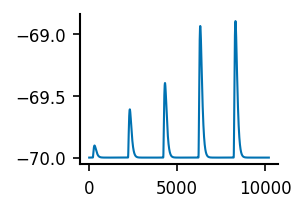

In [16]:
# simulation
nrn.defaultclock.dt = 0.1*nrn.ms
# passive
gL = 1.5*nrn.siemens/nrn.meter**2
EL = -70*nrn.mV                
Es = 0*nrn.mV                  
# synaptic
taus = 5.*nrn.ms
w = 0.4*nrn.nS
# equation
eqs='''
Im = gL * (EL - v) : amp/meter**2
Is = gs * (Es - v) : amp (point current)
gs : siemens
'''


results = {'Nstim':5, 'Nrepeat':20, 'interstim':200}
results['events'] = 20+np.arange(results['Nstim'])*results['interstim']
results['Nsyns'] = 1+np.arange(results['Nstim'])*2

for case in ['single-syn-uniform', 'uniform', 'biased', 'single-syn-biased']:

    results[case] = {'Vm':[]}
    
    for repeat in range(results['Nrepeat']):
        
        np.random.seed(repeat)

        neuron = nrn.SpatialNeuron(morphology=BRT,
                                   model=eqs,
                                   Cm= 1 * nrn.uF / nrn.cm ** 2,    
                                   Ri= 200 * nrn.ohm * nrn.cm)
        neuron.v = EL

        if 'single-syn' in case:
            spike_times = np.arange(Nsynapses)*results['interstim']
            spike_IDs = np.arange(Nsynapses)
        else:
            spike_IDs, spike_times, synapses = np.empty(0, dtype=int), np.empty(0), np.empty(0, dtype=int)
            for e, ns in zip(results['events'], results['Nsyns']):
                s = np.random.choice(np.arange(Nsynapses), ns, replace=False)
                spike_times = np.concatenate([spike_times,
                    e+np.arange(len(s))*nrn.defaultclock.dt/nrn.ms])
                spike_IDs = np.concatenate([spike_IDs, np.array(s, dtype=int)])

        results[case]['spike_times_%i'%repeat] = spike_times
        results[case]['spike_IDs_%i'%repeat] = spike_IDs

        stimulation = nrn.SpikeGeneratorGroup(len(LOCS['single-syn']),
                                              np.array(spike_IDs, dtype=int),
                                              spike_times*nrn.ms)

        ES = nrn.Synapses(stimulation, neuron,
                           model='''dg/dt = -g/taus : siemens (clock-driven)
                                    gs_post = g : siemens (summed)''',
                           on_pre='g += w',
                           method='exponential_euler')

        for ipre, iseg_post in enumerate(LOCS[case.replace('single-syn-', '')]): # connect spike IDs to a given location
            ES.connect(i=ipre, j=iseg_post)

        # recording and running
        M = nrn.StateMonitor(neuron, ('v'), record=[0])
        nrn.run((200+np.max(spike_times))*nrn.ms)
        results[case]['Vm'].append(np.array(M.v[0]/nrn.mV))
        
        results[case]['t'] = np.array(M.t/nrn.ms)

# np.save('results.npy', results)

pt.plt.plot(np.mean(results['uniform']['Vm'], axis=0))

In [20]:
LOCS['uniform']

array([26, 27, 28, 29, 30, 31, 32, 33, 34, 35])

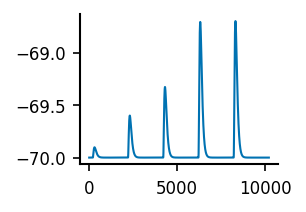

In [17]:
# results = np.load('results.npy', allow_pickle=True).item()

# build linear prediction from single-syn
def build_linear_pred_trace(results):

    # build a dicionary with the individual responses
    
    for case in ['uniform', 'biased']:
    
        results['%s-linear-pred' % case] = {'Vm':[], 't':results[case]['t']}
        linear_pred = []
        results['%s-single-syn-kernel' % case] = []

        for repeat in range(results['Nrepeat']):

            # building single synapse kernel resp to build the linear resp
            results['%s-single-syn-kernel' % case] = {}
            for i, e in zip(results['single-syn-%s'%case]['spike_IDs_%i'%repeat],
                            results['single-syn-%s'%case]['spike_times_%i'%repeat]):

                t_cond = (results['single-syn-%s' % case]['t']>e) &  (results['single-syn-%s' % case]['t']<e+150)
                results['%s-single-syn-kernel' % case][str(i)] = results['single-syn-%s' % case]['Vm'][repeat][t_cond]
                results['%s-single-syn-kernel' % case][str(i)]-= results['%s-single-syn-kernel' % case][str(i)][0]

            # then re-building the patterns
            linear_pred = np.array(0*results[case]['t']-70)
            k=0
            for i, e in zip(results[case]['spike_IDs_%i'%repeat],
                            results[case]['spike_times_%i'%repeat]):

                i0 = np.flatnonzero(results[case]['t']>e)[0] # & (results[case]['t']<(e+160))
                N=len(results['%s-single-syn-kernel' % case][str(i)])
                linear_pred[i0:i0+N] += results['%s-single-syn-kernel' % case][str(i)] 
            results['%s-linear-pred' % case]['Vm'].append(linear_pred)

    return results, linear_pred

results, linear_pred = build_linear_pred_trace(results)
pt.plt.plot(np.mean(results['uniform-linear-pred']['Vm'], axis=0))

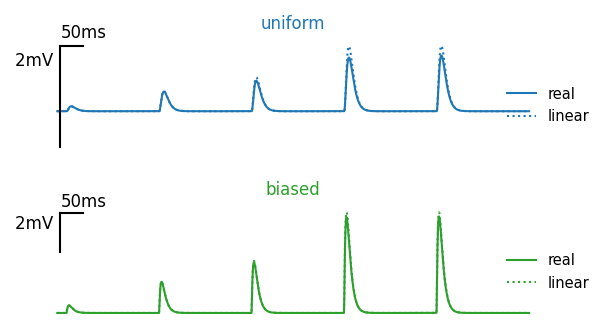

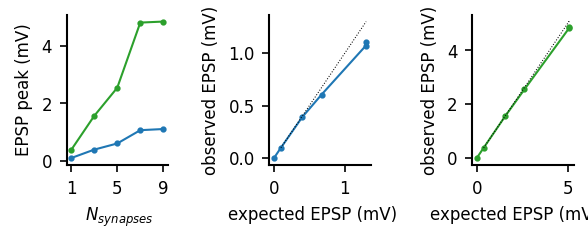

In [18]:
for case in ['uniform', 'biased', 'uniform-linear-pred', 'biased-linear-pred']:

    results[case]['depol'] = []
    results[case]['depol-sd'] = []

    for event in results['events']:

        t_cond = (results[case]['t']>event) & (results[case]['t']<=event+100)

        imax = np.argmax(np.mean(results[case]['Vm'], axis=0)[t_cond])
        results[case]['depol'].append(np.mean(results[case]['Vm'], axis=0)[t_cond][imax]+70)
        results[case]['depol-sd'].append(np.std(results[case]['Vm'], axis=0)[t_cond][imax])

fig2, AX = pt.plt.subplots(2, figsize=(4,2.4))
pt.plt.subplots_adjust(right=.99, hspace=0.5)

fig3, AX1 = pt.plt.subplots(1, 3, figsize=(5.2,1.3))
pt.plt.subplots_adjust(left=0.25, right=.9, wspace=1.)

AX1[0].set_ylabel('EPSP peak (mV)')
AX1[0].set_xlabel(' $N_{synapses}$ ')
for ax in AX1[1:]:
    ax.set_xlabel('expected EPSP (mV)   ')
    ax.set_ylabel('observed EPSP (mV)')
for ax, ax1, case, color in zip(AX, AX1[1:], ['uniform', 'biased'], ['tab:blue', 'tab:green']):
    ax.plot(results[case]['t'], np.mean(results[case]['Vm'],axis=0), color=color, label='real')
    ax.plot(results[case]['t'], np.mean(results[case+'-linear-pred']['Vm'],axis=0), ':', color=color, label='linear')
    ax.set_ylabel('$V_m$ (mV)')
    ax.set_xlabel('time (ms)')
    ax.set_title(case, color=color)
    pt.draw_bar_scales(ax, Ybar=2, Ybar_label='2mV ', Xbar=50, Xbar_label='50ms', remove_axis='both')
    AX1[0].plot(results['Nsyns'], results[case]['depol'], 'o-', color=color, label=case, lw=1, ms=2)
    ax1.plot([0]+results[case+'-linear-pred']['depol'], [0]+results[case]['depol'],
             'o-', color=color, label=case, lw=1, ms=2)
    ax1.plot(results[case+'-linear-pred']['depol'], results[case+'-linear-pred']['depol'], 'k:', lw=0.5)
    ax.legend(loc=(0.9,0.2), frameon=False, fontsize=7)
AX1[0].set_xticks([1,5,9])

#fig2.savefig(os.path.join(os.path.expanduser('~'), 'Desktop', '2.svg'))
#fig3.savefig(os.path.join(os.path.expanduser('~'), 'Desktop', '3.svg'))

In [ ]:
pt.plt.plot(results['single-syn-uniform']['Vm'].flatten()[::10])

In [ ]:
results['single-syn-uniform']